### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBSSBBBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12376
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|    10|[80 49 40 4C E0 D...|1949.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     1|[30 54 40 4C A0 D...|1950.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 C9 40 4C 40 5...|1951.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[E0 D4 30 D5 F0 D...|1952.0|SBSSBBBS|
|   1269.2| 42.6767|-113.5003|       TMAX|USC00105980|     0|[80 4D 80 4D A0 5...|1953.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [31]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00108906')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00108906'
33 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1822.7|    43.7|  -114.35|       TOBS|USC00108906|     1|[20 D0 00 00 A0 D...|1938.0|SBSSBBBS|
|   1822.7|    43.7|  -114.35|       TOBS|USC00108906|     1|[40 CC 80 4D E0 D...|1939.0|SBSSBBBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(33, 365)

In [84]:
Query_station="SELECT DISTINCT station, latitude, longitude FROM weather WHERE latitude > '43.5' AND longitude < '-114'"
print Query_station
df_s = sqlContext.sql(Query_station)
print df_s.count(),'rows'
df_s.show()


SELECT DISTINCT station, latitude, longitude FROM weather WHERE latitude > '43.5' AND longitude < '-114'
8 rows
+-----------+--------+---------+
|    station|latitude|longitude|
+-----------+--------+---------+
|USS0014F08S|    43.6|-114.6667|
|USC00103940| 43.5186|-114.3025|
|USC00103942| 43.5667|-114.3333|
|USS0014F16S|    43.7|-114.1667|
|USR0000IOHI| 43.6008|-114.3158|
|USC00104845| 43.6842|-114.3603|
|USC00108906|    43.7|  -114.35|
|USC00103580|    43.6|  -114.35|
+-----------+--------+---------+



In [85]:
Query_year="SELECT DISTINCT year, station, latitude, longitude FROM weather "
print Query_year
df_s = sqlContext.sql(Query_year)
print df_s.count(),'rows'
df_s.show()


SELECT DISTINCT year, station, latitude, longitude FROM weather 
2801 rows
+------+-----------+--------+---------+
|  year|    station|latitude|longitude|
+------+-----------+--------+---------+
|1993.0|USC00107040| 43.3111|-114.0742|
|2002.0|USC00107040| 43.3111|-114.0742|
|1993.0|USC00106877| 42.6283|-113.7622|
|1991.0|USC00103297| 43.0428|-112.4133|
|1976.0|USC00104845| 43.6842|-114.3603|
|1919.0|USC00104670| 42.7325|-114.5192|
|1955.0|USW00024156| 42.9203|-112.5711|
|1995.0|USC00100915| 43.1969|-112.3531|
|1917.0|USC00107968| 42.6042|-113.7575|
|2010.0|US1IDPW0001| 42.7914|-113.0151|
|2004.0|USS0013F13S| 43.7167|-113.8333|
|1965.0|USW00024145| 43.5164|-112.0672|
|1986.0|USW00024145| 43.5164|-112.0672|
|1962.0|USC00102676| 43.7306|-111.1125|
|1991.0|USC00102676| 43.7306|-111.1125|
|1986.0|USC00103110| 43.3167|  -114.75|
|1973.0|USC00104456| 43.3456|-111.7847|
|2005.0|USC00104456| 43.3456|-111.7847|
|2006.0|USR0000IARC| 43.6231|-113.3872|
|1925.0|USC00104588|    43.4|   -111.3|
+----

In [ ]:
def plot_mean_std_t(m,fig,axis):
    mean=STAT[m]['Mean']/10*1.8+32
    std=np.sqrt(STAT[m]['Var'])/100*1.8
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

plot_pair(['TMIN','TMAX'],plot_mean_std_t)
savefig('r_figures/TMIN,TMAX.png')


### Script for plotting yearly plots

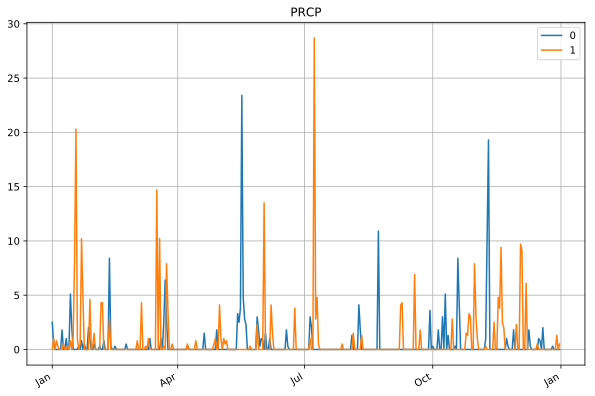

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


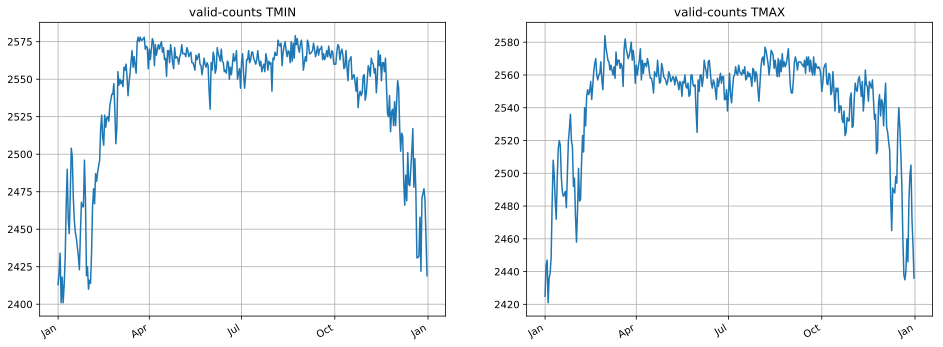

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

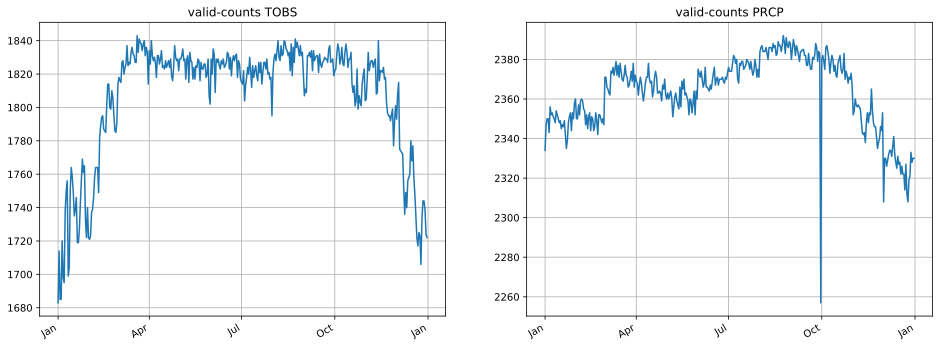

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

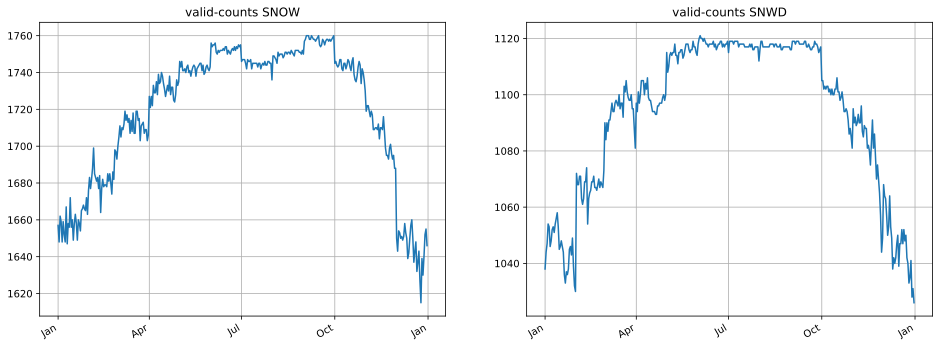

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [73]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    axis.legend(['avg + std', 'avg', 'avg - std'])

In [63]:
def plot_mean_std_temperature(m,fig,axis):
    mean=STAT[m]['Mean']/10*1.8+32
    std=np.sqrt(STAT[m]['Var'])/10*1.8
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    axis.legend(['avg + std', 'avg', 'avg - std'])

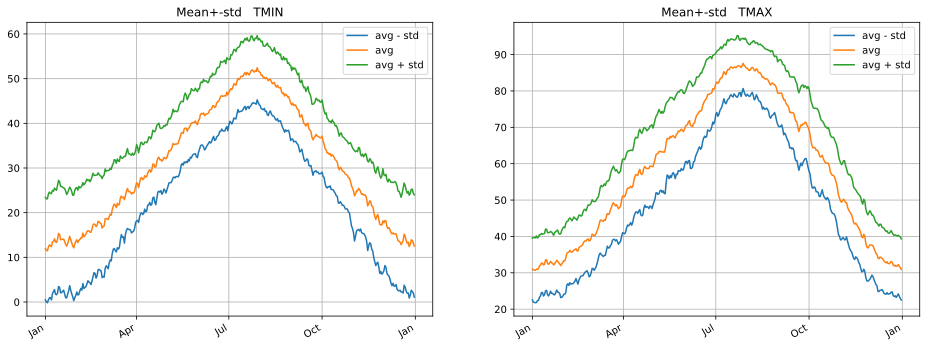

In [59]:
plot_pair(['TMIN','TMAX'],plot_mean_std_temperature)
savefig('r_figures/TMIN,TMAX.svg')

In [74]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

In [81]:
def plot_mean_std_prcp(m,fig,axis):
    mean=STAT[m]['Mean']/3*3.55/10
    std=np.sqrt(STAT[m]['Var'])/3*3.55/10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)
    axis.legend(['avg + std', 'avg', 'avg - std'])
fig, ax = subplots(figsize=(8, 6))
plot_mean_std_prcp('PRCP', fig, ax)
savefig('r_figures/PRCP.svg')

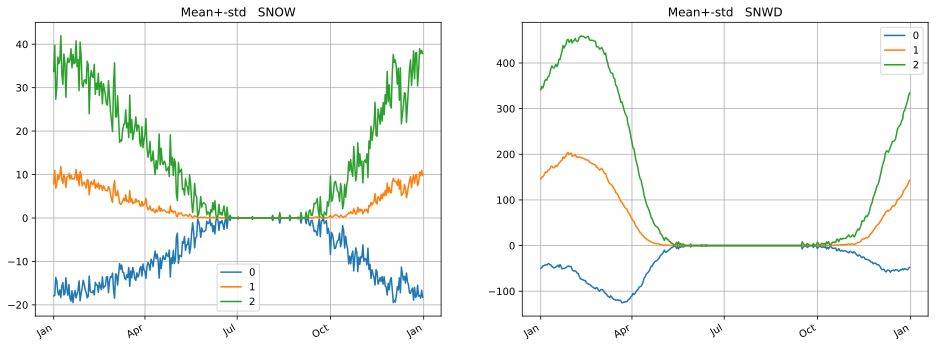

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

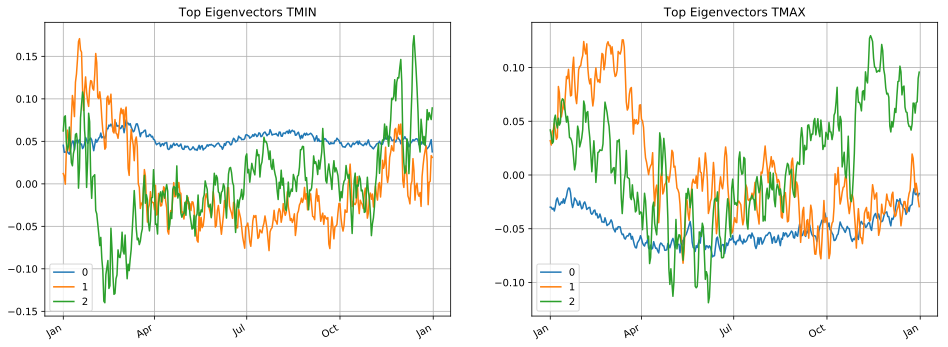

In [14]:
plot_pair(['TMIN','TMAX'],plot_eigen)

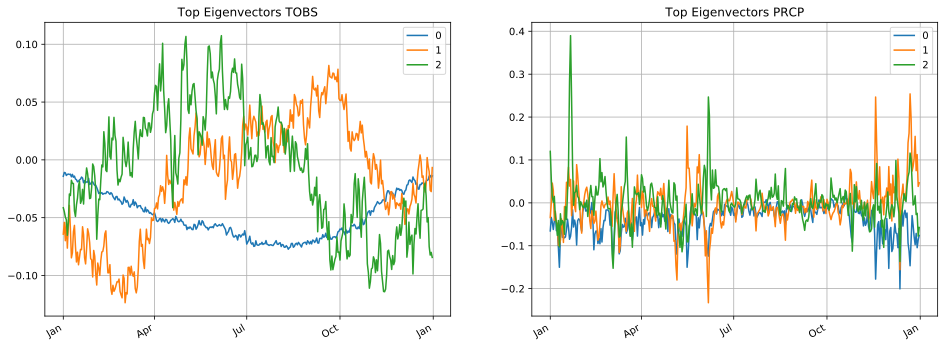

In [15]:
plot_pair(['TOBS','PRCP'],plot_eigen)

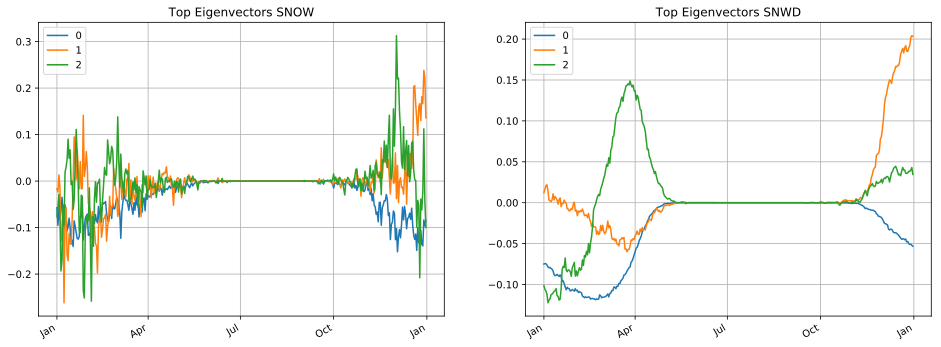

In [16]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [19]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

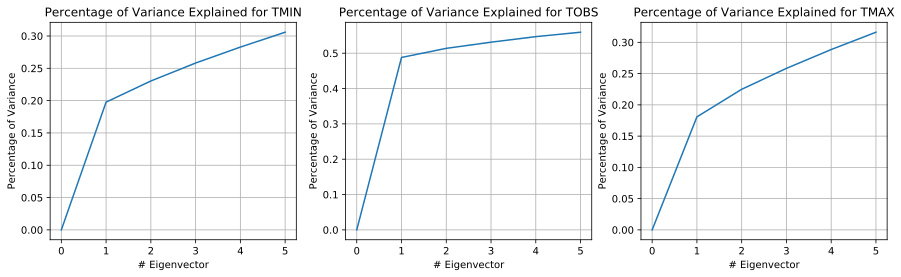

In [20]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

In [ ]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()